In [1]:
import numpy as np
import pandas as pd
import pickle as pkl
from scipy import stats
import matplotlib.pyplot as plt
import seaborn as sns
import lightning as L
import torch
from torch import nn
import torch.nn.functional as F
from sklearn.preprocessing import StandardScaler, MinMaxScaler
from tqdm.notebook import trange


%matplotlib inline
sns.set_theme()

In [2]:
class StockPricePredictor(L.LightningModule):
    def __init__(self,
                 input_size: int,
                 hidden_size: int,
                 num_layers: int,
                 output_size: int,
                 learning_rate: float,
                 train_losses: list[int],
                 test_losses: list[int]):
        super().__init__()
        self.lstm = nn.LSTM(input_size, hidden_size, num_layers, batch_first=True)
        self.linear = nn.Linear(hidden_size, output_size)
        self.train_losses = train_losses
        self.test_losses = test_losses
        self.learning_rate = learning_rate
    
    def forward(self, x: torch.Tensor):
        out, _ = self.lstm(x)
        out = self.linear(out[:, -1, :])
        return out
    
    def configure_optimizers(self):
        optimizer = torch.optim.Adam(self.parameters(), lr=self.learning_rate)
        return optimizer
    
    def training_step(self, batch, batch_idx):
        x, y = batch
        y_hat = self(x)
        loss = F.mse_loss(y_hat, y)
        self.log("train_loss", loss, on_epoch=True, on_step=True, prog_bar=False)
        return loss
    
    def validation_step(self, batch, batch_idx):
        x, y = batch
        y_hat = self(x)
        loss = F.mse_loss(y_hat, y)
        self.log("val_loss", loss, on_epoch=True, on_step=True, prog_bar=False)
        return loss
    
    def on_train_epoch_end(self):
        self.train_losses.append(self.trainer.callback_metrics["train_loss"].item())
        self.test_losses.append(self.trainer.callback_metrics["val_loss"].item())

## Load data

In [3]:
with open("../data/final/sp500-price-volume.pkl", "rb") as f:
    sp500_df = pkl.load(f)

with open("../data/final/sp500-price-volume-sentiment.pkl", "rb") as f:
    sp500_sentiment_df = pkl.load(f)

def split_data(df: pd.DataFrame,
               train_size: float = 0.8,
               lbp: int = 30,
               lfp: int = 1) -> tuple[np.ndarray, np.ndarray, np.ndarray, np.ndarray, StandardScaler]:
    """
    lbp: look back period
    lfp: look forward period
    """
    X_train = []
    y_train = []
    X_test = []
    y_test = []

    tickers = df["Ticker"].unique()

    for ticker in tickers:
        ticker_df = df[df["Ticker"] == ticker]
        ticker_df = ticker_df.drop("Ticker", axis=1)
        ticker_df = ticker_df.set_index("Date")
        ticker_array = ticker_df.sort_index().values
        
        train_count = int(ticker_array.shape[0] * train_size)
        train = ticker_array[:train_count]
        test = ticker_array[train_count:]

        ticker_X_train = []
        ticker_y_train = []
        ticker_X_test = []
        ticker_y_test = []


        for i in range(lbp, train.shape[0] - lfp + 1):
            ticker_X_train.append(train[i - lbp:i, :])
            ticker_y_train.append(train[i:i + lfp, 0])
        
        for i in range(lbp, test.shape[0] - lfp + 1):
            ticker_X_test.append(test[i - lbp:i, :])
            ticker_y_test.append(test[i:i + lfp, 0])

        X_train.append(ticker_X_train)
        y_train.append(ticker_y_train)
        X_test.append(ticker_X_test)
        y_test.append(ticker_y_test)
    
    X_train = np.array(X_train)
    y_train = np.array(y_train)
    X_test = np.array(X_test)
    y_test = np.array(y_test)

    X_scaler = MinMaxScaler(feature_range=(0, 1))
    y_scaler = MinMaxScaler(feature_range=(0, 1))
    
    X_train = X_scaler.fit_transform(X_train.reshape(-1, X_train.shape[-1])).reshape(X_train.shape[0] * X_train.shape[1], X_train.shape[2], -1)
    X_test = X_scaler.transform(X_test.reshape(-1, X_test.shape[-1])).reshape(X_test.shape[0] * X_test.shape[1], X_test.shape[2], -1)
    y_train = y_scaler.fit_transform(y_train.reshape(-1, y_train.shape[-1])).reshape(y_train.shape[0] * y_train.shape[1], y_train.shape[2])
    y_test = y_scaler.transform(y_test.reshape(-1, y_test.shape[-1])).reshape(y_test.shape[0] * y_test.shape[1], y_test.shape[2])

    return X_train, y_train, X_test, y_test, y_scaler

In [18]:
lookback = 90

with open(f"./final/lookback-{lookback}/no-sentiment-model.pkl", "rb") as f:
    ns_model = pkl.load(f)

with open(f"./final/lookback-{lookback}/sentiment-model.pkl", "rb") as f:
    s_model = pkl.load(f)

with open(f"./final/lookback-{lookback}/no-sentiment-test-losses.pkl", "rb") as f:
    ns_test_losses = pkl.load(f).reshape(-1)

with open(f"./final/lookback-{lookback}/sentiment-test-losses.pkl", "rb") as f:
    s_test_losses = pkl.load(f).reshape(-1)

(_, _, X_test_ns, y_test_ns, _) = split_data(sp500_df, train_size=0.8, lbp=lookback, lfp=1)
(_, _, X_test_s, y_test_s, _) = split_data(sp500_sentiment_df, train_size=0.8, lbp=lookback, lfp=1)

print(f"X_test_ns shape: {X_test_ns.shape}")
print(f"y_test_ns shape: {y_test_ns.shape}")
print()
print(f"X_test_s shape: {X_test_s.shape}")
print(f"y_test_s shape: {y_test_s.shape}")

X_test_ns shape: (13662, 90, 2)
y_test_ns shape: (13662, 1)

X_test_s shape: (13662, 90, 3)
y_test_s shape: (13662, 1)


### Plot losses

Final No Sentiment Test Loss: 0.0002651250106282532
Final Sentiment Test Loss: 0.00023299262102227658


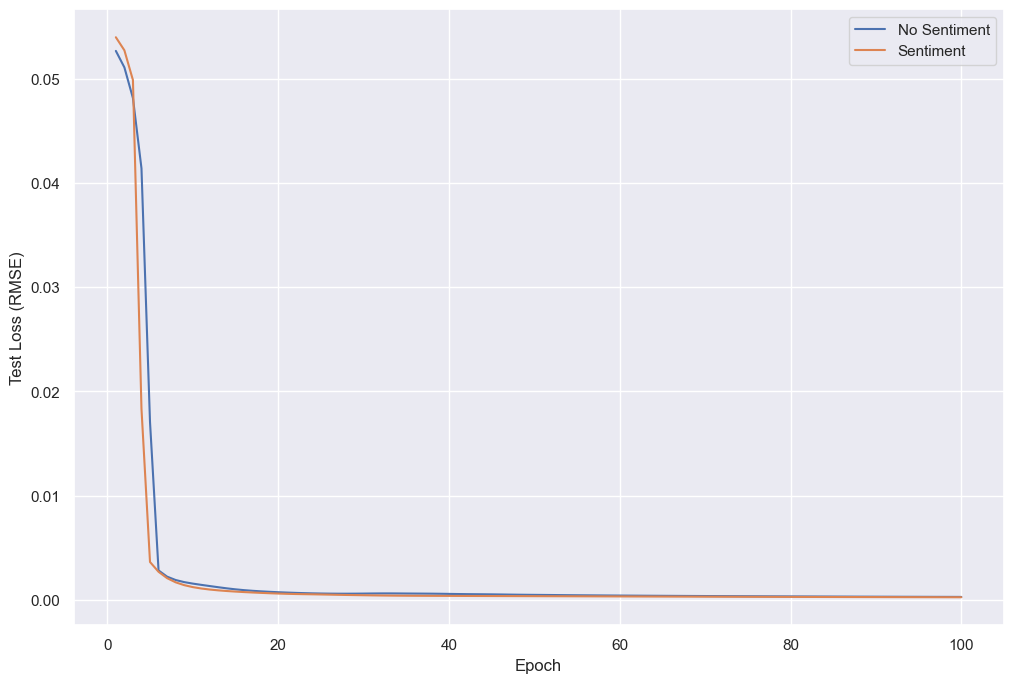

In [19]:
fig, ax = plt.subplots(1, 1, figsize=(12, 8))
sns.lineplot(x=np.arange(1, len(ns_test_losses) + 1), y=ns_test_losses, ax=ax, label="No Sentiment")
sns.lineplot(x=np.arange(1, len(s_test_losses) + 1), y=s_test_losses, ax=ax, label="Sentiment")
ax.set_xlabel("Epoch")
ax.set_ylabel("Test Loss (RMSE)")

print(f"Final No Sentiment Test Loss: {ns_test_losses[-1]}")
print(f"Final Sentiment Test Loss: {s_test_losses[-1]}")

### Model Predictions

In [20]:
ns_model.eval()
s_model.eval()

y_hat_ns = []
y_hat_s = []

with torch.no_grad():
    for i in trange(X_test_ns.shape[0]):
        ns_X = torch.from_numpy(X_test_ns[i, :, :]).float().reshape(1, lookback, -1)
        s_X = torch.from_numpy(X_test_s[i, :, :]).float().reshape(1, lookback, -1)

        y_hat_ns.append(ns_model(ns_X)[0,0].item())
        y_hat_s.append(s_model(s_X)[0,0].item())

y_hat_ns = np.array(y_hat_ns)
y_hat_s = np.array(y_hat_s)
y_test = y_test_ns[:, 0]

  0%|          | 0/13662 [00:00<?, ?it/s]

### Hypothesis Testing

<Axes: ylabel='Count'>

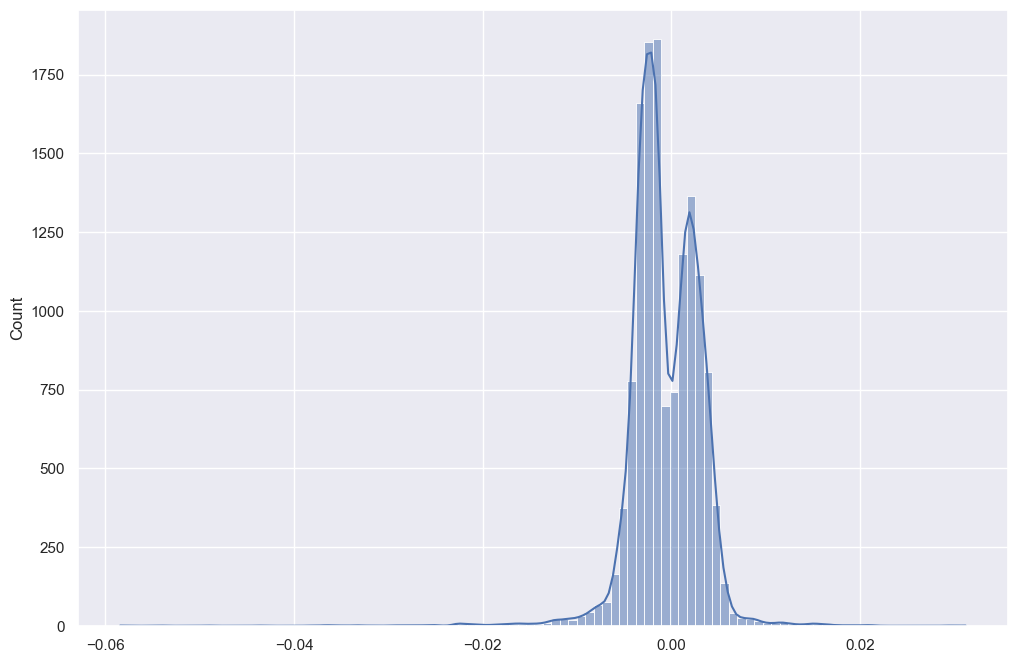

In [21]:
y_hat_s_error = np.sqrt((y_hat_s - y_test) ** 2)
y_hat_ns_error = np.sqrt((y_hat_ns - y_test) ** 2)
y_hat_diff = y_hat_s_error - y_hat_ns_error


fig, ax = plt.subplots(1, 1, figsize=(12, 8))
sns.histplot(y_hat_diff, ax=ax, kde=True, bins=100)

No Sentiment Mean Error: 0.0100
No Sentiment Std Error: 0.0128

With Sentiment Mean Error: 0.0094
With Sentiment Std Error: 0.0120


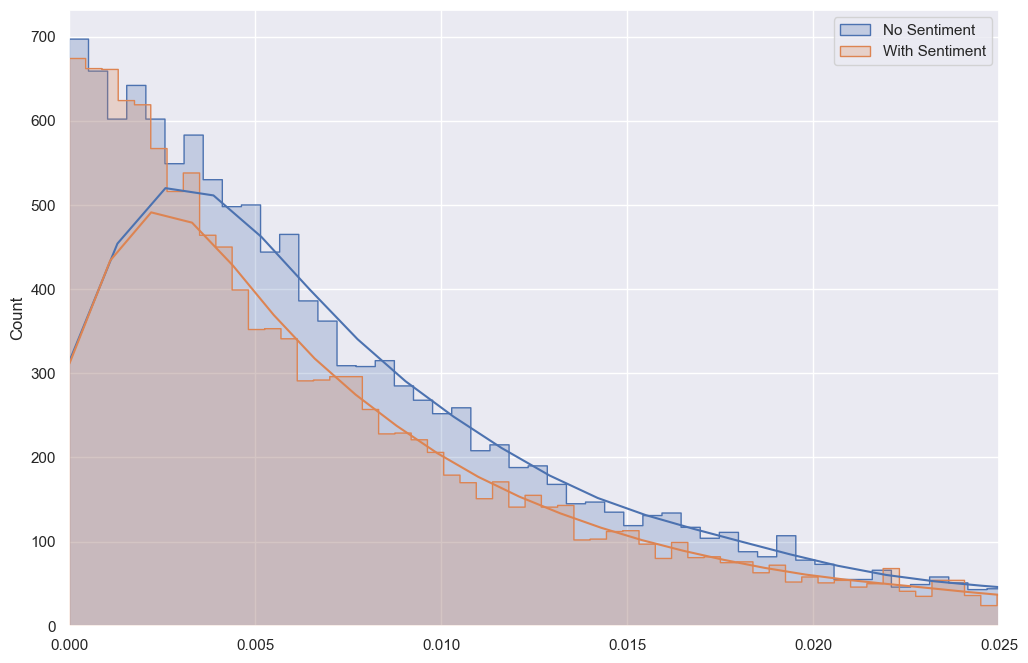

In [22]:
fig, ax = plt.subplots(1, 1, figsize=(12, 8))
sns.histplot(y_hat_ns_error, ax=ax, kde=True, alpha=0.25, bins=500, element="step", label="No Sentiment")
sns.histplot(y_hat_s_error, ax=ax, kde=True, alpha=0.25, bins=500, element="step", label="With Sentiment")
ax.legend()
ax.set_xlim(0, 0.025)

print(f"No Sentiment Mean Error: {y_hat_ns_error.mean():.4f}")
print(f"No Sentiment Std Error: {y_hat_ns_error.std():.4f}")
print()
print(f"With Sentiment Mean Error: {y_hat_s_error.mean():.4f}")
print(f"With Sentiment Std Error: {y_hat_s_error.std():.4f}")

In [23]:
# determine if the difference is normally distributed

from scipy.stats import shapiro

stat, p = shapiro(y_hat_diff)
print(f"w-stat: {stat}, p-value: {p}")

if p > 0.05:
    print("Probably Gaussian")
else:
    print("Probably not Gaussian")

w-stat: 0.8783969879150391, p-value: 0.0
Probably not Gaussian


/Users/pranav/Projects/cos497/venv/lib/python3.10/site-packages/scipy/stats/_morestats.py:1882: UserWarning: p-value may not be accurate for N > 5000.
  warnings.warn("p-value may not be accurate for N > 5000.")


In [24]:
# determine if the difference is statistically significant using wilcoxon signed-rank test

from scipy.stats import wilcoxon

stat, p = wilcoxon(y_hat_s_error, y_hat_ns_error, alternative="less")
print(f"stat: {stat}, p-value: {p}")

if p > 0.05:
    print("y_hat_s_error not significantly less than y_hat_ns_error")
else:
    print("y_hat_s_error significantly less than y_hat_ns_error")

stat: 37098996.0, p-value: 5.819990927095368e-96
y_hat_s_error significantly less than y_hat_ns_error
